In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 스마트팜 배출량에 대한 예측
- smart_farm_final.csv

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

In [190]:
#data = pd.read_csv("smart_farm_final.csv").sample(n = 50000)
org_data = pd.read_csv("smart_farm_final.csv")
org_data.shape

(148168, 57)

시간 데이터 처리하기
- 연도 : numerical
- 월 : non numerical
- 일 : non numerical
- 시 : non numerical
- 분 : non numerical

In [191]:
data = org_data.drop(["시간","년월일","년도","월","일","시","분"],axis=1)
#data = org_data.drop(["시간","년월일","분"],axis=1)

#### 팬코일 B동 데이터
- 0과 1이 아닌, 0.5 발견
- 반올림 처리하기

In [192]:
data["팬코일 B동"].value_counts()

1.0    93920
0.0    54246
0.5        2
Name: 팬코일 B동, dtype: int64

In [193]:
data["팬코일 B동"] = data["팬코일 B동"].apply(lambda x : 1 if x == 0.5 else x )

In [194]:
data["팬코일 B동"].value_counts()

1.0    93922
0.0    54246
Name: 팬코일 B동, dtype: int64

In [195]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

문자열 칼럼 추출

In [196]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [219]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ["월","일","시",'배기팬','유동팬','팬코일 B동',"차광스크린_개방","열공급량(kWh)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동', "차광스크린_개방"]

object_no_binary = [x for x in object_lst_real if x not in ["배기팬","유동팬","팬코일 B동","차광스크린_개방"]]

In [220]:
num_lst_real

['일사량(W/㎡)',
 '외기온(℃)',
 '외기습도(%)',
 '풍속(m/s)',
 '풍향(º)',
 '내부 온도',
 '내부 습도',
 '차광스크린(수평)',
 '차열스크린(수평)',
 '에너지스크린(수평)',
 '에너지스크린(수직)',
 '천창',
 '환기온도(천창 제어온도)',
 '난방온도(설정온도)',
 '누적강수량',
 '현지기압',
 '해면기압',
 '일조',
 'PM10_1시간',
 'PM25_1시간',
 '오존_1시간',
 '이산화질소_1시간',
 '일산화탄소_1시간',
 '아황산가스_1시간',
 '일출시간',
 '일몰시간',
 '일출3시간후',
 '일출1시간후',
 '일몰3시간후',
 '일몰1시간반전',
 '하루길이',
 '지면온도']

##### binary categorial 은 원핫인코딩(get_dummies)하지 않기
- 희소행렬이 만들어지는 것을 방지하기 위함
- 환기온도도 categorical처럼 보이지만 크기 자체에 의미가 있어서 numerical로

## 변수 선택 이전 스케일링, 로그변환, 이상치 처리

#### 이상치 대체하기

In [199]:
def replace_outlier_zscore(df,columns,n):
    data = df.copy()
    mean = np.mean(data[columns])
    std = np.std(data[columns])
    score_top = int(n)*std + mean
    score_bot = -1*n*std + mean
    
    def cond1(x):
        if x > score_top:
            return score_top
        if x < score_bot:
            return score_bot
        else:
            return x
    data[columns] = data[columns].apply(cond1)
    
    return data[columns]

In [86]:
# data

for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = data[col]  

이상치 개수 확인

In [193]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = replace_outlier_zscore(data,col+"_scale",3)
    
    if (data[col] == data[col+"_scale"]).sum() == 148168:
        pass
    else:
        print(col)
        print("이상치 비율 : ",(148168 - (data[col] == data[col+"_scale"]).sum()) / 148168 * 100)
        print(" ---------------------------------------------- ")
        
    data.drop([col+"_scale"],axis=1,inplace=True)

일사량(W/㎡)
이상치 비율 :  0.35500242967442364
 ---------------------------------------------- 
외기온(℃)
이상치 비율 :  0.22541979374763782
 ---------------------------------------------- 
풍속(m/s)
이상치 비율 :  1.6596026132498245
 ---------------------------------------------- 
내부 온도
이상치 비율 :  0.06816586577398628
 ---------------------------------------------- 
내부 습도
이상치 비율 :  0.8773824307542789
 ---------------------------------------------- 
누적강수량
이상치 비율 :  1.9565628205820422
 ---------------------------------------------- 
현지기압
이상치 비율 :  0.6195669780249446
 ---------------------------------------------- 
해면기압
이상치 비율 :  0.6087684250310459
 ---------------------------------------------- 
PM10_1시간
이상치 비율 :  1.5705145510501592
 ---------------------------------------------- 
PM25_1시간
이상치 비율 :  1.4071864370174396
 ---------------------------------------------- 
오존_1시간
이상치 비율 :  0.20247286863560285
 ---------------------------------------------- 
이산화질소_1시간
이상치 비율 :  0.3624264348577291
 ---------------------

이상치 대체하는 함수

In [200]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col] = replace_outlier_zscore(data,col,3)

#### 1. 숫자형 데이터 스케일링 진행
- 컬럼별로 스케일링 진행

In [201]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [202]:
data.head()

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),...,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
1,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
2,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
3,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
4,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통


In [204]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도',"환기온도(천창 제어온도)"]:
    
    scaler = StandardScaler()
    
    
    data_scaled = scaler.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

In [161]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

"배기팬","유동팬","팬코일 B동","환기온도(천창 제어온도)" 카테고리열 데이터로 스케일링 필요없음
- 환기온도는 numerical로 보면 필요한 것 같기도...

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

X 데이터 처리하기
- dummy 처리
- 왜도 처리

In [221]:
data_scaled = data.copy()
data_scaled.head(3)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),...,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,-0.652558,0.454987,0.646925,-0.875098,0.993241,-0.440184,-1.047478,-0.767925,-0.858997,-0.616693,...,1004,야간,일몰1시간반_후,일몰,-0.138743,좋음,좋음,좋음,보통,보통
1,-0.652558,0.454987,0.646925,-0.602480,1.148526,-0.490463,-0.892186,-0.767925,-0.858997,-0.616693,...,1004,야간,일몰1시간반_후,일몰,-0.138743,좋음,좋음,좋음,보통,보통
2,-0.652558,0.437095,0.646925,-0.261707,-0.804797,-0.591021,-0.692524,-0.767925,-0.858997,-0.616693,...,1004,야간,일몰1시간반_후,일몰,-0.138743,좋음,좋음,좋음,보통,보통


In [222]:
# 년도 데이터를 numerical로 처리하기
Y = data_scaled["열공급량(kWh)"]

X_dummy = pd.get_dummies(data_scaled.drop("열공급량(kWh)",axis=1),columns= object_no_binary)

년월일 데이터 붙이기

In [223]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

In [224]:
data_scaled_final["년도"] = org_data["년도"].values
data_scaled_final["월"] = org_data["월"].values
data_scaled_final["일"] = org_data["일"].values
data_scaled_final["시"] = org_data["시"].values

In [225]:
train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

### 선택된 변수 기반의 예측

- selected_variables : backward로 변수선택
- selected_variables : stepwise로 변수선택
- 2가지 경우 존재

In [226]:
selected_variables = np.load("backward.npy")

변수 다시 한번 재가공

In [229]:
selected_variables = [x for x in selected_variables if x not in ['팬코일 B동_0.5', '년도_2021', '년도_2022',
                                                                '배기팬_0', '배기팬_1','유동팬_0', '유동팬_1','팬코일 B동_0.0',
                                                                 '팬코일 B동_1.0','환기온도(천창 제어온도)_27',
                                                                 '환기온도(천창 제어온도)_28','환기온도(천창 제어온도)_30',
                                                                 '차광스크린_개방_0', '차광스크린_개방_1','팬코일 B동_1.0']]

selected_variables += ["년도","월","일","시","팬코일 B동","배기팬","유동팬","차광스크린_개방","환기온도(천창 제어온도)"]

In [230]:
x_train = train_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_train = train_data["열공급량(kWh)"]

x_test = test_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_test = test_data["열공급량(kWh)"]

In [231]:
x_train.head(3)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),에너지스크린(수평),에너지스크린(수직),...,PM25등급_좋음,년도,월,일,시,팬코일 B동,배기팬,유동팬,차광스크린_개방,환기온도(천창 제어온도)
0,-0.652558,0.454987,0.646925,-0.875098,0.993241,-0.440184,-1.047478,-0.767925,-0.616693,-0.704239,...,0,2021,11,26,0,0.0,0,1,0,-0.339488
1,-0.652558,0.454987,0.646925,-0.602480,1.148526,-0.490463,-0.892186,-0.767925,-0.616693,-0.704239,...,0,2021,11,26,0,0.0,0,1,0,-0.339488
2,-0.652558,0.437095,0.646925,-0.261707,-0.804797,-0.591021,-0.692524,-0.767925,-0.616693,-0.704239,...,0,2021,11,26,0,1.0,0,1,0,-0.339488


년월일 데이터 붙이기

In [233]:
data_transform = pd.concat([x_train,np.log1p(y_train)],axis=1)
data_transform.shape

(129448, 62)

In [234]:
data_transform

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),에너지스크린(수평),에너지스크린(수직),...,년도,월,일,시,팬코일 B동,배기팬,유동팬,차광스크린_개방,환기온도(천창 제어온도),열공급량(kWh)
0,-0.652558,0.454987,0.646925,-0.875098,0.993241,-0.440184,-1.047478,-0.767925,-0.616693,-0.704239,...,2021,11,26,0,0.0,0,1,0,-0.339488,0.641854
1,-0.652558,0.454987,0.646925,-0.602480,1.148526,-0.490463,-0.892186,-0.767925,-0.616693,-0.704239,...,2021,11,26,0,0.0,0,1,0,-0.339488,0.641854
2,-0.652558,0.437095,0.646925,-0.261707,-0.804797,-0.591021,-0.692524,-0.767925,-0.616693,-0.704239,...,2021,11,26,0,1.0,0,1,0,-0.339488,0.641854
3,-0.652558,0.437095,0.646925,0.010911,-0.657685,-0.591021,-0.836725,-0.767925,-0.616693,-0.704239,...,2021,11,26,0,1.0,0,1,0,-0.339488,0.587787
4,-0.652558,0.437095,0.646925,-0.261707,-0.657685,-0.616161,-0.747986,-0.767925,-0.616693,-0.704239,...,2021,11,26,0,1.0,0,1,0,-0.339488,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129443,-0.652558,0.150832,-0.115646,-0.875098,-1.197097,-0.477893,-0.097977,-0.767925,-0.616693,-0.704239,...,2022,2,28,23,1.0,0,1,0,-0.339488,0.641854
129444,-0.652558,0.150832,-0.067986,-0.602480,-1.197097,-0.503033,0.085601,-0.767925,-0.616693,-0.704239,...,2022,2,28,23,1.0,0,1,0,-0.339488,0.587787
129445,-0.652558,0.150832,-0.067986,-0.602480,-1.336036,-0.465323,-0.081893,-0.767925,-0.616693,-0.704239,...,2022,2,28,23,1.0,0,1,0,-0.339488,0.587787
129446,-0.652558,0.150832,-0.067986,-0.602480,-1.368728,-0.440184,-0.083557,-0.767925,-0.616693,-0.704239,...,2022,2,28,23,1.0,0,1,0,-0.339488,0.587787


In [235]:
reg_lunch = setup(
        data = data_transform,
        target='열공급량(kWh)',
        train_size=0.8,
        session_id = 0,
        data_split_shuffle=False,
        normalize = False,
        fold_strategy = 'timeseries',
        numeric_features = ["년도","월"],
        categorical_features = ["일","시","팬코일 B동","배기팬","유동팬","차광스크린_개방"],
        fold = 5,
        verbose=True,
        transform_target = False,
        silent= False, n_jobs= 1)

,Description,Value
0,session_id,0
1,Target,열공급량(kWh)
2,Original Data,"(129448, 62)"
3,Missing Values,False
4,Numeric Features,55
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(103558, 108)"


In [236]:
best_5_d = compare_models(sort = 'RMSE', n_select = 5,round=4,cross_validation=True,verbose=True)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1259,0.0300,0.1722,0.2858,0.1331,0.5382,15.1100
lightgbm,Light Gradient Boosting Machine,0.1310,0.0327,0.1793,0.2205,0.1391,0.5392,0.7660
ada,AdaBoost Regressor,0.1387,0.0331,0.1810,0.2141,0.1422,0.6125,6.8840
omp,Orthogonal Matching Pursuit,0.1424,0.0344,0.1847,0.1760,0.1430,0.5680,0.0820
et,Extra Trees Regressor,0.1344,0.0349,0.1862,0.1672,0.1438,0.5734,34.2400
rf,Random Forest Regressor,0.1382,0.0352,0.1865,0.1615,0.1447,0.5699,42.9460
lasso,Lasso Regression,0.1779,0.0431,0.2072,-0.0277,0.1630,0.6547,0.0760
en,Elastic Net,0.1779,0.0431,0.2073,-0.0278,0.1630,0.6546,0.0740
llar,Lasso Least Angle Regression,0.1821,0.0437,0.2087,-0.0415,0.1644,0.6734,0.0700
knn,K Neighbors Regressor,0.1597,0.0474,0.2172,-0.1374,0.1659,0.6006,2.1800


[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
              random_state=0, reg

### 모델 생성 및 튜닝
- ada boost
- orthogonal mathcing pursuit

In [239]:
gbr_model = create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1600,0.0422,0.2054,0.0743,0.1615,0.8136
1,0.1180,0.0272,0.1649,0.2686,0.1249,0.4599
2,0.1263,0.0338,0.1838,0.2136,0.1405,0.4796
3,0.1183,0.0235,0.1533,0.4380,0.1212,0.4848
4,0.1069,0.0236,0.1536,0.4343,0.1176,0.4533
Mean,0.1259,0.0300,0.1722,0.2858,0.1331,0.5382
SD,0.0181,0.0071,0.0200,0.1382,0.0162,0.1382


In [ ]:
tuned_models = []

best_model = tune_model(gbr_model, fold= 3, n_iter = 100, optimize = 'RMSE', verbose = True, choose_better = True)
tuned_models.append(best_model)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:24:33
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [79]:
import math
import time

In [80]:
start = time.time()

tuned_models = []

omp_model = tune_model(omp_model, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(omp_model)

math.factorial(100000)
end = time.time()

print(f"{end - start:.5f} sec")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1628,0.0411,0.2026,-0.0136,0.1537,0.6035
1,0.1211,0.0299,0.1729,0.2902,0.1328,0.4295
2,0.1304,0.0286,0.1691,0.3247,0.1325,0.5093
Mean,0.1381,0.0332,0.1816,0.2004,0.1397,0.5141
SD,0.0179,0.0056,0.0150,0.1520,0.0100,0.0711


12.40907 sec


모델 저장하기
- adaboost_ver1
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- Normalization

In [343]:
import joblib
joblib.dump(ada_model, 'adaboost_ver1.pkl')
# model = joblib.load('adaboost_ver1.pkl') : 모델 읽어오기

['adaboost_ver1.pkl']

모델 불러오기

In [136]:
import joblib
ada_model = joblib.load('adaboost_ver1.pkl')

모델로 예측하기

In [166]:
final_model = omp_model

In [167]:
prediction = predict_model(final_model, data = x_test)

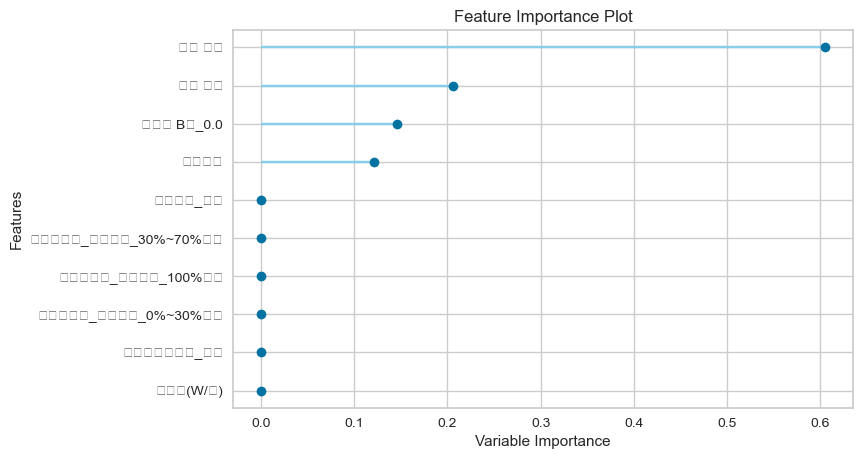

,Feature,Value
0,일사량(W/㎡),0.048684
1,외기온(℃),0.048684
30,차열스크린_온도조절_25도~26도,0.048684
31,차열스크린_광도조절_800미만,0.048684
32,차열스크린_개방조절_0%~30%개방,0.048684
33,차열스크린_개방조절_100%개방,0.048684
34,차열스크린_개방조절_30%~70%개방,0.048684
35,시간범주_그외,0.048684
36,시간범주_야간,0.048684
37,시간범주_주간,0.048684


In [231]:
lr = create_model('lr')
plot_model(final_model, plot = 'feature')

# this is how you can recreate the table
import pandas as pd
pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(lr.coef_[0])}).sort_values(by='Value', ascending=False)

#### 로그역변환 반드시 하기

In [168]:
prediction["Label"]

129448    0.386486
129449    0.389202
129450    0.389968
129451    0.389886
129452    0.390097
            ...   
148163    0.217120
148164    0.219690
148165    0.217740
148166    0.217718
148167    0.219263
Name: Label, Length: 18720, dtype: float64

In [169]:
predict_df = org_data.iloc[129448:,:].copy()
predict_df["열공급량(kWh)"] = prediction["Label"].apply(lambda x : np.exp(x)-1)

In [170]:
predict_df["년월일"].value_counts()

2022-03-12    1440
2022-03-08    1440
2022-03-11    1440
2022-03-13    1440
2022-03-20    1440
2022-03-05    1440
2022-03-19    1440
2022-03-06    1440
2022-03-07    1440
2022-03-04    1440
2022-03-18    1440
2022-03-09    1440
2022-03-10    1440
Name: 년월일, dtype: int64

In [171]:
predict_df[["년월일","열공급량(kWh)"]].head()

,년월일,열공급량(kWh)
129448,2022-03-04,0.471799
129449,2022-03-04,0.475803
129450,2022-03-04,0.476933
129451,2022-03-04,0.476812
129452,2022-03-04,0.477124


In [172]:
predict_df.rename(columns={'년도':'yy'},inplace=True)
predict_df.rename(columns={'월':'mm'},inplace=True)
predict_df.rename(columns={'일':'dd'},inplace=True)

제출용 데이터로 가공하기

In [173]:
submit_df = pd.read_csv("2-1_검증데이터셋.csv")

In [174]:
submit_df = pd.merge(submit_df[["yy","mm","dd"]],predict_df[["yy","mm","dd","시","분","열공급량(kWh)"]],
                     on = ["yy","mm","dd"], how = "inner").reset_index()

submit_df = submit_df.groupby(["yy","mm","dd"]).sum().reset_index()

In [175]:
submit_df.drop(["index","시","분"],axis=1,inplace=True)

In [176]:
submit_df.rename(columns={'열공급량(kWh)':'heat_supply_day'},inplace=True)

In [150]:
submit_df.to_csv("220104_ada_model_ver1.1.csv",encoding="utf-8-sig",index=False)

plot 그려보기

In [161]:
predict_df[["년월일","시","분","열공급량(kWh)"]]

,년월일,시,분,열공급량(kWh)
129448,2022-03-04,0,0,0.141266
129449,2022-03-04,0,1,0.300338
129450,2022-03-04,0,2,0.300338
129451,2022-03-04,0,3,0.300338
129452,2022-03-04,0,4,0.300338
...,...,...,...,...
148163,2022-03-20,23,55,0.141266
148164,2022-03-20,23,56,0.141266
148165,2022-03-20,23,57,0.141266
148166,2022-03-20,23,58,0.141266


In [177]:
compare_df = pd.concat([org_data[["년월일","시","분","열공급량(kWh)"]].iloc[:129448,:],
                       predict_df[["년월일","시","분","열공급량(kWh)"]]],
                      ignore_index = True)

In [178]:
compare = compare_df.groupby(["년월일"]).sum().reset_index()

In [179]:
#compare[["년월일","열공급량(kWh)"]].to_csv("test.csv",encoding="utf-8-sig",index=False)

<AxesSubplot:xlabel='년월일'>

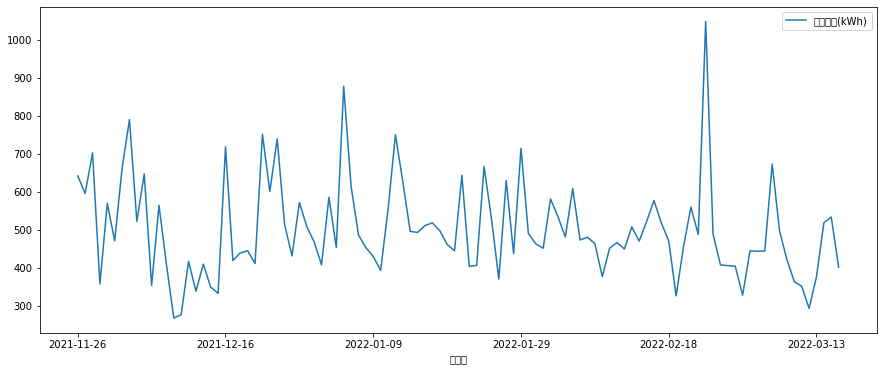

In [180]:
fig, ax = plt.subplots(1,1, figsize = (15,6))
compare[["년월일","열공급량(kWh)"]].set_index("년월일").plot(ax=ax)